# **Finite difference solver for Cahn-Hilliard equation**
Total free energy
$$
G(c, \nabla c)=\int_V \left\{ f_{chem}(c)+f_{grad}(\nabla c) \right\}dV
$$
Chemical free energy density
$$
f_{chem}(c) = Ac^2(1-c)^2
$$
Gradient energy density
$$
f_{grad}(\nabla c) = \frac{a}{2}\left| \nabla c\ \right|^2
$$
Cahn-Hilliard equation assuming $M_c$ is constant. 
$$
\frac{\partial c}{\partial t} = \nabla \cdot \left( M_{c} \nabla \frac{\delta G}{\delta c} \right) =  M_{c}\nabla^2 \mu
$$
Total diffusion potential
$$
\mu = \frac{\delta G}{\delta c} = \mu_{chem} + \mu_{grad} 
$$
Chemital part of diffusion potential
$$
\mu_{chem} = \frac{\delta f_{chem}}{\delta c} = 2Ac(1-c)^2-2Ac^2(1-c) = \mu_{chem}(c)
$$
Gradient part of diffusion potential
$$
\mu_{grad}=\frac{\delta f_{grad}}{\delta (\nabla c)} = - a \nabla^{2}c 
$$
## **Finite difference discretization**
Chemical part of diffusion potantial at a finite difference grid [i,j]
$$
\mu^{chem}_{i,j} = 2Ac^t_{i,j}\left(1-c^t_{i,j}\right)^2-2A(c^{t}_{i,j})^2\left(1-c^t_{i,j}\right) 
$$
Gradient part of diffusion potential at a finite difference grid [i,j]
$$
\mu^{grad}_{i,j} = - a\left\{
\frac{c^t_{i+1,j}-2c^t_{i,j}+c^t_{i-1,j}}{\Delta x^2} +
\frac{c^t_{i,j+1}-2c^t_{i,j}+c^t_{i,j-1}}{\Delta y^2}\right\}
$$
Total diffusion potential at a finite difference grid [i,j]
$$
\mu^t_{i,j} = \mu^{chem}_{i,j} + \mu^{grad}_{i,j}
$$
Laplacian of total diffusion potential
$$
\mu^t_{i,j}=\frac{\mu^t_{i+1,j}-2\mu^t_{i,j}+\mu^t_{i-1,j}}{\Delta x^2}+\frac{\mu^t_{i,j+1}-2\mu^t_{i,j}+\mu^t_{i,j-1}}{\Delta y^2}
$$
Concentration $c$ at $t+\Delta t$
$$
c_{i,j}^{t+\Delta t}=c_{i,j}^{t}+\Delta tM_c\nabla^{2}\mu^t_{i,j}
$$

## **Import libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from numba import jit

## **Set parameters**

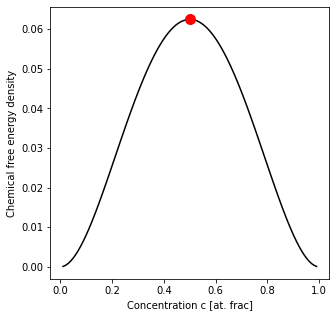

In [2]:
nx = ny = 1024
dx = dy = 1.0
total_step = 1000
dt = 1.0e-2
A = 2.0
mobility = 1.0
grad_coef = 1.0
c0 = 0.5

fig = plt.figure(figsize=(5,5))
cc = np.linspace(0.01, 0.99, 100);
plt.plot(cc, cc**2*(1.-cc)**2 ,color='black')
plt.plot(c0, c0**2*(1.-c0)**2 ,color='r',marker='o',markersize=10)
plt.xlabel('Concentration c [at. frac]')
plt.ylabel('Chemical free energy density')
plt.show()

## **Define Numpy arrays and set initial distribution**

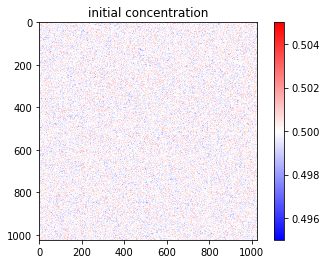

In [3]:
con = np.zeros([nx, ny])
con_new = np.zeros([nx, ny])

con = c0 + 0.01 * (0.5 - np.random.rand(nx, ny))
plt.imshow(con, cmap='bwr')
plt.title('initial concentration')
plt.colorbar()
plt.show() 

## **Define function to solve Cahn-Hilliard equation**

In [4]:
@jit(nopython=True)
def update(con, con_new):
  for j in range(ny):
    for i in range(nx):
      
      ip = i + 1
      im = i - 1
      jp = j + 1
      jm = j - 1
      ipp = i + 2
      imm = i - 2
      jpp = j + 2
      jmm = j - 2

      if ip > nx-1:
        ip = ip - nx
      if im < 0:
        im = im + nx
      if jp > ny-1:
        jp = jp - ny
      if jm < 0:
        jm = jm + ny
      if ipp > nx-1:
        ipp = ipp - nx
      if imm < 0:
        imm = imm + nx
      if jpp > ny-1:
        jpp = jpp - ny
      if jmm < 0:
        jmm = jmm + ny
      
      cc = con[i,j] # at (i,j) "centeral point"
      ce = con[ip,j] # at (i+1.j) "eastern point"
      cw = con[im,j] # at (i-1,j) "western point"
      cs = con[i,jm] # at (i,j-1) "southern point"
      cn = con[i,jp] # at (i,j+1) "northern point"
      cse = con[ip,jm] # at (i+1, j-1)
      cne = con[ip,jp]
      csw = con[im,jm]
      cnw = con[im,jp]
      cee = con[ipp,j]  # at (i+2, j)
      cww = con[imm,j]
      css = con[i,jmm]
      cnn = con[i,jpp]
      
      mu_chem_c = 2.*A*cc*(1.-cc)**2 - 2.*A*cc**2*(1.-cc) # chemical term of the diffusion potential
      mu_chem_w = 2.*A*cw*(1.-cw)**2 - 2.*A*cw**2*(1.-cw)  
      mu_chem_e = 2.*A*ce*(1.-ce)**2 - 2.*A*ce**2*(1.-ce) 
      mu_chem_n = 2.*A*cn*(1.-cn)**2 - 2.*A*cn**2*(1.-cn) 
      mu_chem_s = 2.*A*cs*(1.-cs)**2 - 2.*A*cs**2*(1.-cs)  
      
      mu_grad_c = -grad_coef*( (ce - 2.0*cc + cw)/dx/dx + (cn  - 2.0*cc + cs)/dy/dy) # gradient term of the diffusion potential
      mu_grad_w = -grad_coef*( (cc - 2.0*cw + cww)/dx/dx + (cnw - 2.0*cw + csw)/dy/dy)
      mu_grad_e = -grad_coef*( (cee - 2.0*ce + cc)/dx/dx + (cne - 2.0*ce + cse)/dy/dy)  
      mu_grad_n = -grad_coef*( (cne - 2.0*cn + cnw)/dx/dx + (cnn - 2.0*cn + cc)/dy/dy) 
      mu_grad_s = -grad_coef*( (cse - 2.0*cs + csw)/dx/dx + (cc  - 2.0*cs + css)/dy/dy)
      
      mu_c = mu_chem_c + mu_grad_c # total diffusion potental
      mu_w = mu_chem_w + mu_grad_w 
      mu_e = mu_chem_e + mu_grad_e 
      mu_n = mu_chem_n + mu_grad_n 
      mu_s = mu_chem_s + mu_grad_s
      
      laplace_mu = (mu_w - 2.0*mu_c + mu_e)/dx/dx + (mu_n - 2.0 *mu_c + mu_s)/dy/dy
      con_new[i,j] = con[i,j] + mobility*laplace_mu*dt  

## **Time integration**

It takes  61755.30457496643 ms


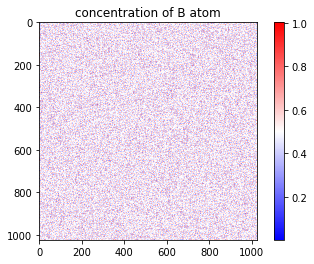

In [5]:
start = time()
for nstep in range(total_step):
    update(con, con_new)
    con[:,:] = con_new[:,:] # swap c at time t and c at time t+dt
    
end = time()
print("It takes ", (end-start)*1000.0, "ms")

plt.imshow(con, cmap='bwr')
plt.title('concentration of B atom')
plt.colorbar()
plt.show()